In [37]:
import torch
from torch import nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import os,PIL,pathlib

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [17]:
data_dir = './4-data/'
data_dir = pathlib.Path(data_dir)

In [60]:
data_paths = list(data_dir.glob('*'))
classeNames = [str(path).split("/")[1] for path in data_paths]
classeNames

['Others', 'Monkeypox']

In [68]:
data_paths = list(data_dir.glob('*'))
classeNames = [path.name for path in data_paths]
classeNames

['Others', 'Monkeypox']

In [24]:
total_dir = './4-data/'
train_transforms = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
    transforms.Normalize( mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225])
])

In [28]:
total_data = datasets.ImageFolder(total_dir,transform=train_transforms)
total_data

Dataset ImageFolder
    Number of datapoints: 2147
    Root location: ./4-data/
    StandardTransform
Transform: Compose(
               Resize(size=[224, 224], interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [29]:
total_data.class_to_idx

{'Monkeypox': 0, 'Others': 1}

In [30]:
train_size = int(0.8 * len(total_data))
test_size  = len(total_data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(total_data, [train_size, test_size])
train_dataset, test_dataset

(<torch.utils.data.dataset.Subset at 0x7f142c07ffd0>,
 <torch.utils.data.dataset.Subset at 0x7f142c07fbd0>)

In [31]:
train_size,test_size

(1717, 430)

In [35]:
batch_size = 32
train_dl = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_dl  = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size)

In [36]:
for X, y in test_dl:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([32, 3, 224, 224])
Shape of y:  torch.Size([32]) torch.int64


In [38]:
class Network_bn(nn.Module):
    def __init__(self):
        super(Network_bn, self).__init__()
        """
        nn.Conv2d()函数：
        第一个参数（in_channels）是输入的channel数量
        第二个参数（out_channels）是输出的channel数量
        第三个参数（kernel_size）是卷积核大小
        第四个参数（stride）是步长，默认为1
        第五个参数（padding）是填充大小，默认为0
        """
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(12) # 这里定义的是批量初始化，传入的是通道数
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(12)
        self.pool = nn.MaxPool2d(2,2)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=5, stride=1, padding=0)
        self.bn4 = nn.BatchNorm2d(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=5, stride=1, padding=0)
        self.bn5 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(24*50*50, len(classeNames))

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))      
        x = F.relu(self.bn2(self.conv2(x)))     
        x = self.pool(x)                        
        x = F.relu(self.bn4(self.conv4(x)))     
        x = F.relu(self.bn5(self.conv5(x)))  
        x = self.pool(x)                        
        x = x.view(-1, 24*50*50)
        x = self.fc1(x)

        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

model = Network_bn().to(device)
model

Using cuda device


Network_bn(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(12, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(24, 24, kernel_size=(5, 5), stride=(1, 1))
  (bn5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=60000, out_features=2, bias=True)
)

In [39]:
loss_fn    = nn.CrossEntropyLoss() # 创建损失函数
learn_rate = 1e-4 # 学习率
opt        = torch.optim.SGD(model.parameters(),lr=learn_rate)

In [40]:
def train(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset) # 训练集的大小
    num_batches = len(dataloader)
    train_loss,train_acc = 0.0,0.0
    
    for X, y in dataloader:  # 获取图片及其标签
        X, y = X.to(device), y.to(device)
        
        # 计算预测误差
        pred = model(X)          # 网络输出
        loss = loss_fn(pred, y)  # 计算网络输出和真实值之间的差距，targets为真实值，计算二者差值即为损失
        
        # 反向传播
        optimizer.zero_grad()  # grad属性归零
        loss.backward()        # 反向传播
        optimizer.step()       # 每一步自动更新
        
        # 记录acc与loss
        train_acc  += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss.item()
            
    train_acc  /= size
    train_loss /= num_batches

    return train_acc, train_loss

In [41]:
def test (dataloader, model, loss_fn):
    size        = len(dataloader.dataset)  # 测试集的大小，一共10000张图片
    num_batches = len(dataloader)          # 批次数目，313（10000/32=312.5，向上取整）
    test_loss, test_acc = 0, 0
    
    # 当不进行训练时，停止梯度更新，节省计算内存消耗
    with torch.no_grad():
        for imgs, target in dataloader:
            imgs, target = imgs.to(device), target.to(device)
            
            # 计算loss
            target_pred = model(imgs)
            loss        = loss_fn(target_pred, target)
            
            test_loss += loss.item()
            test_acc  += (target_pred.argmax(1) == target).type(torch.float).sum().item()

    test_acc  /= size
    test_loss /= num_batches

    return test_acc, test_loss

In [42]:
epochs     = 20
train_loss = []
train_acc  = []
test_loss  = []
test_acc   = []

for epoch in range(epochs):
    model.train()
    epoch_train_acc, epoch_train_loss = train(train_dl, model, loss_fn, opt)
    
    model.eval()
    epoch_test_acc, epoch_test_loss = test(test_dl, model, loss_fn)
    
    train_acc.append(epoch_train_acc)
    train_loss.append(epoch_train_loss)
    test_acc.append(epoch_test_acc)
    test_loss.append(epoch_test_loss)
    
    template = ('Epoch:{:2d}, Train_acc:{:.1f}%, Train_loss:{:.3f}, Test_acc:{:.1f}%，Test_loss:{:.3f}')
    print(template.format(epoch+1, epoch_train_acc*100, epoch_train_loss, epoch_test_acc*100, epoch_test_loss))
print('Done')

Epoch: 1, Train_acc:62.6%, Train_loss:0.664, Test_acc:65.6%，Test_loss:0.628
Epoch: 2, Train_acc:68.5%, Train_loss:0.610, Test_acc:70.5%，Test_loss:0.566
Epoch: 3, Train_acc:73.8%, Train_loss:0.537, Test_acc:77.7%，Test_loss:0.489
Epoch: 4, Train_acc:75.8%, Train_loss:0.501, Test_acc:71.8%，Test_loss:0.535
Epoch: 5, Train_acc:77.7%, Train_loss:0.489, Test_acc:79.7%，Test_loss:0.480
Epoch: 6, Train_acc:81.2%, Train_loss:0.445, Test_acc:84.3%，Test_loss:0.422
Epoch: 7, Train_acc:82.8%, Train_loss:0.420, Test_acc:85.6%，Test_loss:0.394
Epoch: 8, Train_acc:84.2%, Train_loss:0.404, Test_acc:80.2%，Test_loss:0.467
Epoch: 9, Train_acc:85.5%, Train_loss:0.389, Test_acc:81.9%，Test_loss:0.394
Epoch:10, Train_acc:86.2%, Train_loss:0.368, Test_acc:87.5%，Test_loss:0.348
Epoch:11, Train_acc:88.1%, Train_loss:0.353, Test_acc:89.7%，Test_loss:0.331
Epoch:12, Train_acc:88.5%, Train_loss:0.340, Test_acc:89.8%，Test_loss:0.319
Epoch:13, Train_acc:88.9%, Train_loss:0.326, Test_acc:90.8%，Test_loss:0.308
Epoch:14, Tr

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


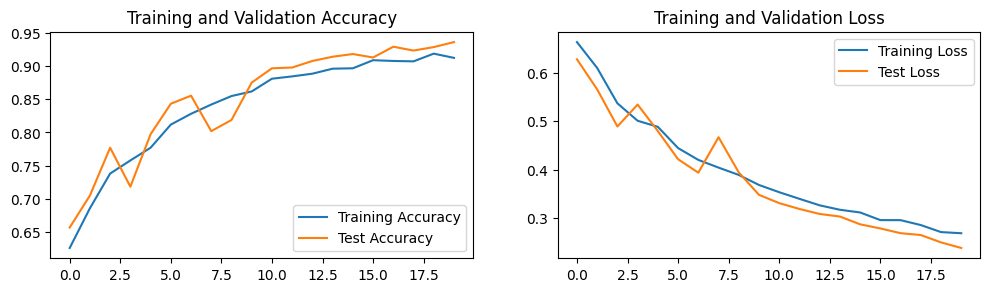

In [43]:
import matplotlib.pyplot as plt
#隐藏警告
import warnings
warnings.filterwarnings("ignore")               #忽略警告信息
plt.rcParams['font.sans-serif']    = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False      # 用来正常显示负号
plt.rcParams['figure.dpi']         = 100        #分辨率

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, test_acc, label='Test Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, test_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [69]:
from PIL import Image 

classes = list(total_data.class_to_idx)

def predict_one_image(image_path, model, transform, classes):
    
    test_img = Image.open(image_path).convert('RGB') # 这里需要注意需要把图片改成RGB格式
    plt.imshow(test_img)  # 展示预测的图片

    test_img = transform(test_img)
    print(test_img.shape) 
    img = test_img.to(device).unsqueeze(0) # 这里注意测试的时候，需要为测试的图片补充一个维度
    
    model.eval() # 将模型设置为测试格式
    output = model(img)
    print(output)
    _,pred = torch.max(output,dim=1) # 查看列的最大值,返回最大值所在的索引
    pred_class = classes[pred]
    print(f'预测结果是：{pred_class}')

torch.Size([3, 224, 224])
tensor([[ 0.5076, -0.6680]], device='cuda:0', grad_fn=<AddmmBackward>)
预测结果是：Monkeypox


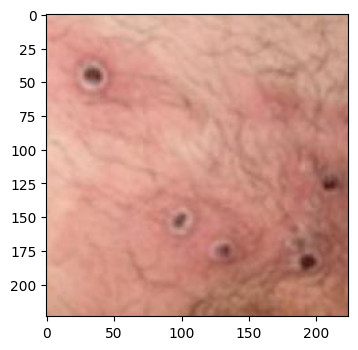

In [70]:
predict_one_image(image_path='./4-data/Monkeypox/M01_01_00.jpg', 
                  model=model, 
                  transform=train_transforms, 
                  classes=classes)

In [48]:
# 模型保存
PATH = './model.pth'  # 保存的参数文件名
torch.save(model.state_dict(), PATH)

# 将参数加载到model当中
model.load_state_dict(torch.load(PATH, map_location=device))

<All keys matched successfully>